In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load Training Data


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")

train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Manipulation

I am trying to create some useful features based on the `Name` column. Weather the individual has Mrs. or Mr. in their name may corralate with surviving. Perhaps the name length also makes an impact. People with titles in their names may be more likley to survive. 

In [3]:
def wrangle_data(df):
    df["Mrs"] = df["Name"].str.contains("Mrs. ", case=False)
    df["Master"] = df["Name"].str.contains("Master. ", case=False)
    df["Miss"] = df["Name"].str.contains("Miss. ", case=False)
    df["Mr"] = df["Name"].str.contains("Mr. ", case=False)
    df["name_len"] = df["Name"].str.len()
    df["fam"] = df["SibSp"] + df["Parch"]
    df["cabin_num"] = df["Cabin"].str.extract(r"(\d+)")[0].astype("Int64")
    df["cabin_char"] = df["Cabin"].str.extract(r"([A-Z]+)")
    return df
    
train_data = wrangle_data(train_data)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Mrs,Master,Miss,Mr,name_len,fam,cabin_num,cabin_char
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,False,False,True,23,1,<NA>,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,False,False,False,51,1,85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,False,True,False,22,0,<NA>,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,False,False,False,44,1,123,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,False,False,True,24,0,<NA>,NaN


## Feature Selection

Let's see what features seem to be good predictors of if an individual survives. 

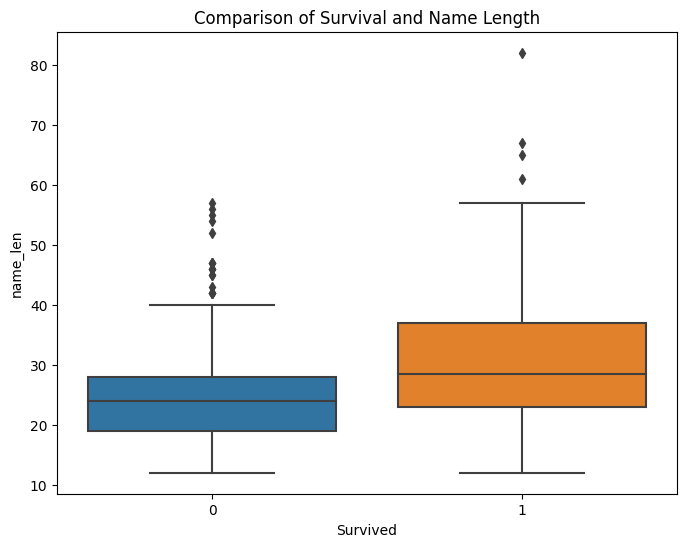

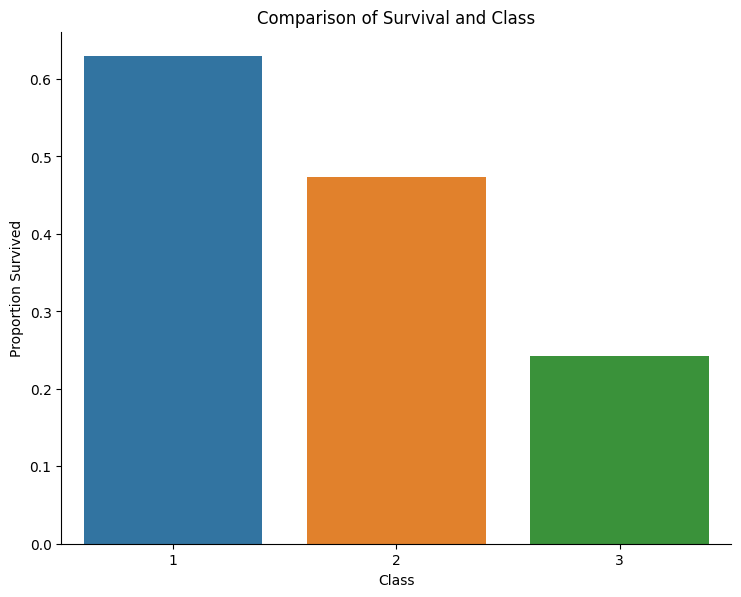

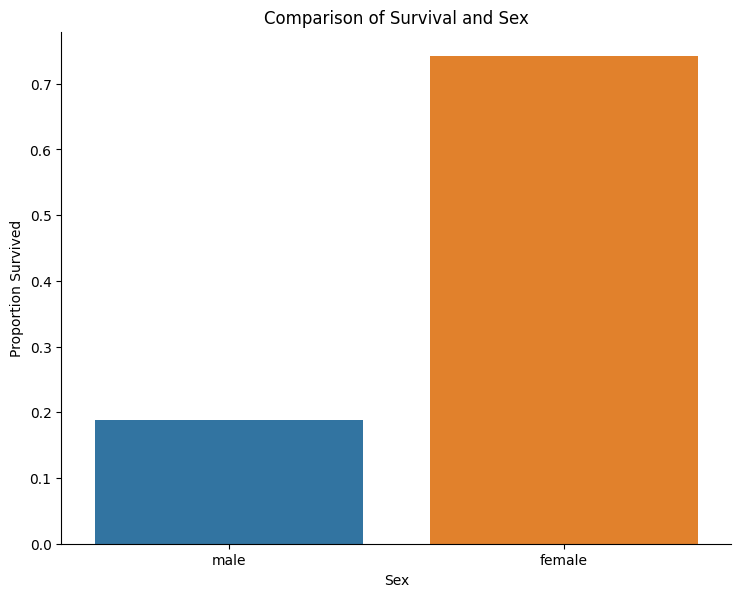

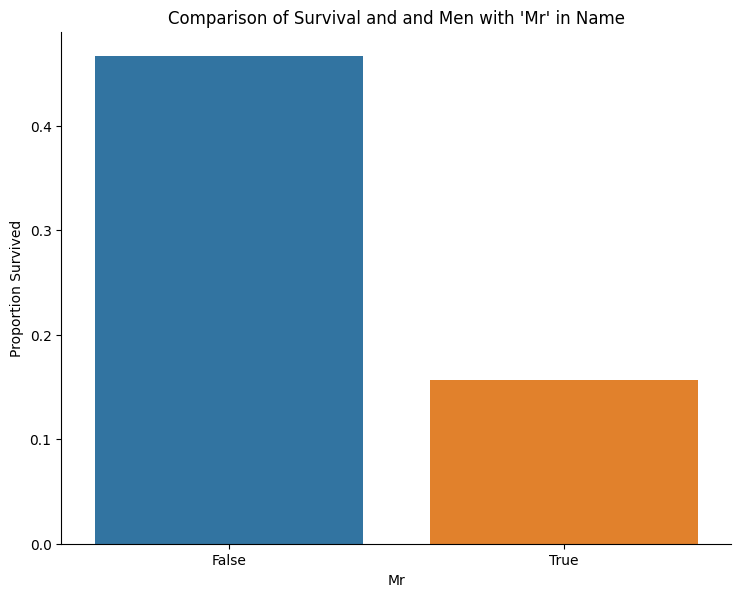

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 6))
plt.title("Comparison of Survival and Name Length")
sns.boxplot(data=train_data, x="Survived", y="name_len")

class_plot = sns.catplot(data=train_data, x="Pclass", y="Survived", kind="bar", errorbar=None)
class_plot.fig.set_size_inches(8, 6)
class_plot.ax.set_title("Comparison of Survival and Class")
class_plot.ax.set_ylabel("Proportion Survived")
class_plot.ax.set_xlabel("Class")

sex_plot = sns.catplot(data=train_data, x="Sex", y="Survived", kind="bar", errorbar=None)
sex_plot.fig.set_size_inches(8, 6)
sex_plot.ax.set_title("Comparison of Survival and Sex")
sex_plot.ax.set_ylabel("Proportion Survived")


mr_plot = sns.catplot(data=train_data.loc[train_data.Sex == "male"], x="Mr", y="Survived", kind="bar", errorbar=None)
mr_plot.fig.set_size_inches(8, 6)
mr_plot.ax.set_title("Comparison of Survival and and Men with 'Mr' in Name")
mr_plot.ax.set_ylabel("Proportion Survived")

plt.show()



## Split Data

In [5]:
from sklearn.model_selection import train_test_split

y = train_data["Survived"]

features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", 
            "Embarked", "Mrs", "Mr", "Miss", "name_len", "fam", "cabin_char"]
X = train_data[features]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)


## Missing Values

We can see age has 177 missing values, Cabin 687, and Embarked 2 so these are the colunms we will want to look at closer. 

In [6]:
print(train_data.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Mrs              0
Master           0
Miss             0
Mr               0
name_len         0
fam              0
cabin_num      691
cabin_char     687
dtype: int64


## Age 

From the plot below we can see there is some skewness  in the distributions of Age so I am going to fill missing values using the median.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Ages in Training Data'}, xlabel='Age', ylabel='Count'>

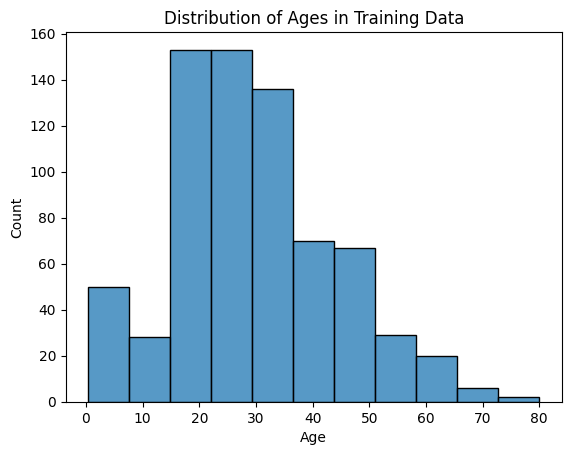

In [7]:
plt.figure()
plt.title("Distribution of Ages in Training Data")
sns.histplot(x=train_data["Age"], bins=11)


## Creating a Pipeline

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

num_features = X_train.columns[X_train.dtypes != "object"]
cat_features = X_train.columns[X_train.dtypes == "object"]

num_transformer = SimpleImputer(strategy="median").set_output(transform="pandas")
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
]).set_output(transform="pandas")

X_train_dummies = preprocessor.fit_transform(X_train, y_train)
X_val_dummies = preprocessor.transform(X_val)


## Model Selection

I will try to estimate the best number of estimators and max depth for a Random Forest Classifier. It apears the 150 is the best number of estimators before the score drops off. The max depth around 12 seems to have the largest scores then the values further away. 

0.7924528301886793
0.7924528301886793
0.7924528301886793
0.7875
0.7875
0.7924528301886793
0.7924528301886793
0.7875
0.7875
0.7848101265822786


<Axes: xlabel='Number of Estimators', ylabel='F1 Score'>

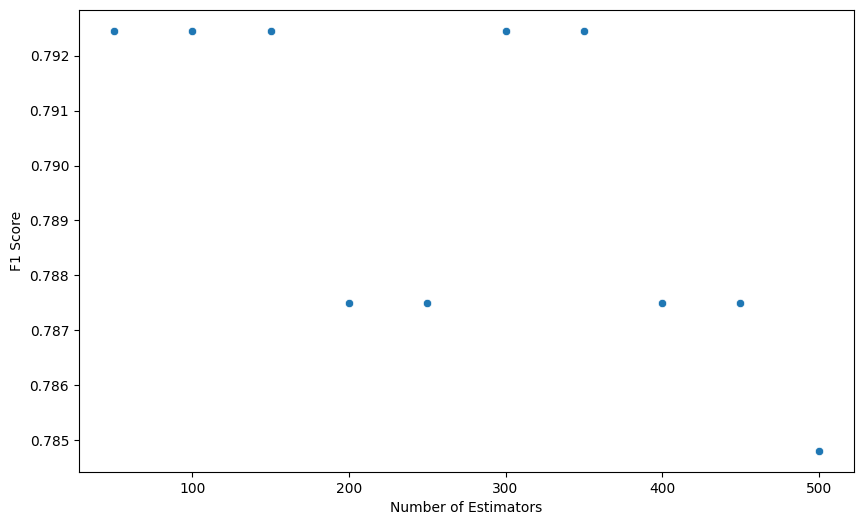

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


n = list(range(50, 550, 50))
scores = []

for i in n:
    model = RandomForestClassifier(n_estimators=i, max_depth=10, random_state=123)
    model.fit(X_train_dummies, y_train)
    train_predictions = model.predict(X_val_dummies)
    score = f1_score(y_val, train_predictions)
    scores.append(score)
    print(score)

plt.figure(figsize=(10,6))
plt.ylabel("F1 Score")
plt.xlabel("Number of Estimators")
sns.scatterplot(x=n, y=scores)


0.8
0.8024691358024691
0.7924528301886793
0.7950310559006212
0.7950310559006212
0.7924528301886793
0.7924528301886793
0.7950310559006212
0.7770700636942677
0.7721518987341773
0.7721518987341773
0.7875
0.7721518987341773
0.779874213836478
0.779874213836478


<Axes: title={'center': 'Score vs Max Depth'}, xlabel='Max Depth', ylabel='F1 Score'>

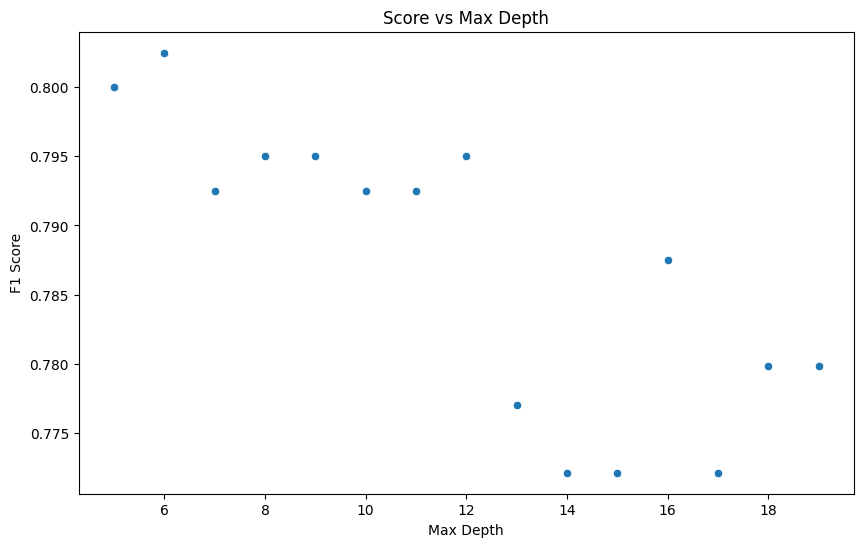

In [10]:
n = list(range(5, 20, 1))
scores = []

for i in n:
    model = RandomForestClassifier(n_estimators=150, max_depth=i, random_state=123)
    model.fit(X_train_dummies, y_train)
    train_predictions = model.predict(X_val_dummies)
    score = f1_score(y_val, train_predictions)
    scores.append(score)
    print(score)

plt.figure(figsize=(10,6))
plt.title("Score vs Max Depth")
plt.ylabel("F1 Score")
plt.xlabel("Max Depth")
sns.scatterplot(x=n, y=scores)

## Random Forest Pipeline

In [11]:
# Load testing data
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data = wrangle_data(test_data)

model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=123)
forest_pipeline = Pipeline(steps=[
    ("preprocesses", preprocessor),
    ("model", model)
])

print("Final Model has 150 estimators and a max depth of 6")

Final Model has 150 estimators and a max depth of 6


## Forest Model Validation

Using cross validation to evaluate random forest model

In [12]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    forest_pipeline, train_data, y,
    cv=5,
    scoring="f1"
)

print("Mean f1 score ", scores.mean())

Mean f1 score  0.7639771136208656


## Gradient Boosting Pipeline and Validation

The Gradient Boosting model performs a bit better than the Random Forest Model. I have found 500 estimators to perform well.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=350, random_state=123)

gradient_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", gradient_model)
])

scores = cross_val_score(
    gradient_pipeline, train_data, y,
    cv=5,
    scoring="f1"
)

print(scores.mean())


0.7695406927701072


## Final Submission

In [14]:
gradient_pipeline.fit(train_data, y)

predictions = gradient_pipeline.predict(test_data)

output = pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived': predictions})

output.to_csv('submission.csv', index=False)